<a href="https://colab.research.google.com/github/SergeiSa/Control-Theory-Slides-Spring-2022/blob/main/Assignment/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default state of the Python script and needed functions

*It is important to run these code snippets before other*

In [5]:
# For transfer function and checking the values obtained during transformation SS -> TF
from scipy.signal import ss2tf
from control import tf as transfer_func
# For LQR method
from scipy.linalg import solve_continuous_are, solve_continuous_lyapunov, solve_discrete_lyapunov
from control import dlqr
# For pole placement method
from scipy.signal import place_poles
from sympy.printing.latex import latex, print_latex
# For Bode plots
from control import bode_plot
# For basic calculations
import numpy as np
import sympy as sp
sp.init_printing()
from numpy.linalg import eig  # Eigenvalues
# For integration
from scipy.integrate import odeint


In [6]:
# x_dot from state space with constant U
def dxdt(x, t, A, B, u):
  return A.dot(x) + B.dot(u)

In [7]:
# For plotting exactly one plot
from matplotlib.pyplot import *

def plot1(t, sol, title_str=''):
  subplot(121)
  plot(t, sol)
  if title_str:
    title(title_str)
  grid(True)
  xlabel('Time $t$')
  ylabel('State $x(t)$')
  show()

In [8]:
# sympy rounding for expressions
# source: https://stackoverflow.com/a/60284977
def round_expr(expr, num_digits):
     return expr.xreplace({n.evalf() : n if type(n)==int else sp.Float(n, num_digits) for n in expr.atoms(sp.Number)}) 

In [9]:
# my number
n = 20

# Task 1 (5 points)

Given a system for $n = 20$:

<!-- A = 
    [0 0 1 0;
     0 0 0 1;
     n -2 -10/n -2;
     -5 -n/10 0 -3]; -->

$$ 
\begin{cases}
\dot x = 
\begin{bmatrix} 
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
20 & -2 & -0.5 & -2 \\
-5 & -2 & 0 & -3
\end{bmatrix}
x
+ 
\begin{bmatrix} 
0 \\
0 \\
-1\\
1
\end{bmatrix}
u \\
y = \begin{bmatrix} 
1 & 1 & 0 & 0
\end{bmatrix} x
\end{cases}
$$

where $n$ is your number in your group list (ask your TA to give you your number if you don't have one).

### 1 Find its transfer function representation ($y(s) / u(s) = W(s)$).

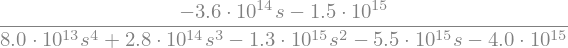

In [10]:
# Solution using sympy and straightforward algorithm
A = sp.Matrix([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])
B = sp.Matrix([[0],
              [0],
              [-1],
              [1]])
C = sp.Matrix([[1, 1, 0, 0]])
D = sp.Matrix([[0]])
s, t = sp.symbols('s, t')
Ys = round_expr(sp.simplify(C * (s * sp.eye(4) - A).inv() * B + D), 2)[0]
Ys


In [11]:
# Solution using scipy
A = [[0, 0, 1, 0],
      [0, 0, 0, 1],
      [n, -2, -10/n, -2],
      [-5, -n/10, 0, -3]]
B = [[0],
    [0],
    [-1],
    [1]]
C = [[1, 1, 0, 0]]
D = 0
tf_num, tf_den = ss2tf(A, B, C, D)
transfer_function = transfer_func(tf_num[0], tf_den)
transfer_function

TransferFunction(array([ 5.68434189e-14, -4.50000000e+00, -1.90000000e+01]), array([  1. ,   3.5, -16.5, -69. , -50. ]))

Let's omit very small coefficient in numerator ($5.684\cdot10^{-14}$, appears from some error presicion of `scipy`) and match coefficients with straightforward calculations.

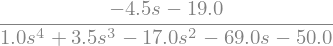

In [12]:
# Matching coefficients with straightforward algorithm and scipy
num, den = sp.fraction(Ys)
num = round_expr(num * (4.5) / (3.6 * 10**14), 2)
den = round_expr(den * (4.5) / (3.6 * 10**14), 2)
tf = num/den
tf

_Remark_: for some reason [Wolframalpha return](https://www.wolframalpha.com/input?i=A%3A+%5B%2F%2Fmath%3A%7B%7B0%2C+0%2C+1%2C+0%7D%2C%7B0%2C+0%2C+0%2C+1%7D%2C%7B20%2C+-2%2C+-0.5%2C+-2%7D%2C%7B5%2C+-2%2C+0%2C+-3%7D%7D%2F%2F%5D+B%3A+%5B%2F%2Fmath%3A%7B%7B0%7D%2C%7B0%7D%2C+%7B-1%7D%2C%7B1%7D%7D%2F%2F%5D+C%3A+%5B%2F%2Fmath%3A%7B%7B1%2C1%2C+0%2C0%7D%7D+%2F%2F%5D+D%3A%5B%2F%2Fmath%3A%7B%7B0%7D%7D%2F%2F%5D) a bit different result, but since the results of straightforward algorithm and scipy are matched I will not use the result of Wolframalpha.

### 2 Propose an ODE representation of the system.


In [13]:
def invL(F):
    return sp.inverse_laplace_transform(F, s, t)
print_latex(invL(num))
print_latex(invL(den))


- 4.5 \mathcal{L}^{-1}_{s}\left[s\right]\left(t\right) - 19.0 \delta\left(t\right)
- 69.0 \mathcal{L}^{-1}_{s}\left[s\right]\left(t\right) - 17.0 \mathcal{L}^{-1}_{s}\left[s^{2}\right]\left(t\right) + 3.5 \mathcal{L}^{-1}_{s}\left[s^{3}\right]\left(t\right) + 1.0 \mathcal{L}^{-1}_{s}\left[s^{4}\right]\left(t\right) - 50.0 \delta\left(t\right)


Numerator: $4.5 \mathcal{L}^{-1}_{s}\left[s\right]\left(t\right) + 19.0 \delta\left(t\right)$

Denominator: $69.0 \mathcal{L}^{-1}_{s}\left[s\right]\left(t\right) + 17.0 \mathcal{L}^{-1}_{s}\left[s^{2}\right]\left(t\right) - 3.5 \mathcal{L}^{-1}_{s}\left[s^{3}\right]\left(t\right) - 1.0 \mathcal{L}^{-1}_{s}\left[s^{4}\right]\left(t\right) + 50.0 \delta\left(t\right)$

ODE form:

$$ y^{[4]} + 3.5y^{[3]} - 17 \ddot y - 69 \dot y - 50 y = - 4.5 \dot u - 19u$$

### 3 Propose a controller (control law $u = -Kx$) that makes the system stable. Do it via pole placement and as an LQR. For LQR show the cost function you chose.


**Pole placement method**

$$ 
\begin{cases}
\mathbf{\dot{x}} = 
\begin{bmatrix} 
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
20 & -2 & -0.5 & -2 \\
-5 & -2 & 0 & -3
\end{bmatrix}
\mathbf{x}
+ 
\begin{bmatrix} 
0 \\
0 \\
-1\\
1
\end{bmatrix}
\mathbf{u} \\
\mathbf{u} = -\mathbf{K}\mathbf{x}=-\begin{bmatrix}
k_1 & k_2 & k_3 & k_4
\end{bmatrix}\mathbf{x}
\end{cases}
$$

$$
\mathbf{\dot{x}}=(\mathbf{A} - \mathbf{B}\mathbf{K})\mathbf{x} = \mathbf{A}_c\mathbf{x}=\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
k_1+20 & k_2-2 & k_3-0.5 & k_4-2\\
-k_1-5 & -k_2-2 & -k_3 & -k_4-3
\end{bmatrix}$$

$$
\det \left(\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
k_1+20 & k_2-2 & k_3-0.5 & k_4-2\\
-k_1-5 & -k_2-2 & -k_3 & -k_4-3
\end{bmatrix} - \begin{bmatrix} \lambda & 0 & 0 & 0\\ 
0 & \lambda & 0 & 0\\
0 & 0 & \lambda & 0\\
0 & 0 & 0 & \lambda\\
\end{bmatrix} \right)=0
$$

Solving the equation leads to four lambda roots. 
The system will be stable if $\operatorname{Re}{\lambda_i} < 0$. Let's assume that $\lambda_1=-1$, $\lambda_2=-2$, $\lambda_3=-3$, $\lambda_4=-4$ which we will call poles.

In [14]:
# Pole placement
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])
B = np.array([[0],
              [0],
              [-1],
              [1]])
P_pp = np.array([-1, -2, -3, -4])

pp = place_poles(A, B, P_pp)

K_pp = pp.gain_matrix
print(f"Calculated gains:\n{K_pp}\n")
# verifying eigenvalues
Lambda, Q = eig(A - B.dot(K_pp))
print(f"Eigen values:\n{Lambda}")


Calculated gains:
[[-26.    2.   -4.5   2. ]]

Eigen values:
[-1. -2. -3. -4.]


Control law is following:
$$u = -\begin{bmatrix}
-26 & 2 & -4.5 & 2
\end{bmatrix}\mathbf{x}$$

**Linear quadratic regulator (LQR) method**

I choose the following cost functions:

performace (state): 
$$ Q = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 4
\end{bmatrix}
$$
energy (input):
$$
R = 
\begin{bmatrix} 
10
\end{bmatrix}
$$

In [15]:
# LQR
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])
B = np.array([[0],
              [0],
              [-1],
              [1]])
Q = np.array([[1, 0, 0, 0],
              [0, 2, 0, 0],
              [0, 0, 3, 0],
              [0, 0, 0, 4]])
R = np.array([[10]])
P_lqr = solve_continuous_are(A, B, Q, R)
K_lqr = (np.linalg.inv(R).dot(B.transpose())).dot(P_lqr)
P = round_expr(sp.Matrix(P_lqr), 2)
K = round_expr(sp.Matrix(K_lqr), 2)
print(r'P = ' + latex(P))
print(r'K = ' + latex(K))


P = \left[\begin{matrix}1.2 \cdot 10^{3} & -78.0 & 2.5 \cdot 10^{2} & -77.0\\-78.0 & 8.0 & -16.0 & 5.2\\2.5 \cdot 10^{2} & -16.0 & 52.0 & -16.0\\-77.0 & 5.2 & -16.0 & 5.4\end{matrix}\right]
K = \left[\begin{matrix}-33.0 & 2.1 & -6.8 & 2.1\end{matrix}\right]


$$
P = \begin{bmatrix}1.2 \cdot 10^{3} & -78.0 & 2.5 \cdot 10^{2} & -77.0\\-78.0 & 8.0 & -16.0 & 5.2\\2.5 \cdot 10^{2} & -16.0 & 52.0 & -16.0\\-77.0 & 5.2 & -16.0 & 5.4\end{bmatrix}
$$

$$
K = \begin{bmatrix}-33.0 & 2.1 & -6.8 & 2.1\end{bmatrix}
$$

Control law is following:
$$u = -\begin{bmatrix}-33.0 & 2.1 & -6.8 & 2.1\end{bmatrix}\mathbf{x}$$

### 4 Show stability of the closed-loop system via eigenvalue analysis.

Using pole placement method we have already know (by our assumption) that real part of eigenvalues is negative, so the system is stable.

Let's compute eigenvalues for obtained control low from LQR method:

In [16]:
A_c = A - B.dot(K_lqr)
l, v = eig(A_c)
print(r'\mathbf{\lambda} = ' + latex(round_expr(sp.Matrix(l), 2)))

\mathbf{\lambda} = \left[\begin{matrix}-0.99\\-2.7\\-4.5\\-4.1\end{matrix}\right]


$$
\mathbf{\lambda} = \begin{bmatrix}-0.99\\-2.7\\-4.5\\-4.1\end{bmatrix}
$$
So, again real part of eigenvalues is negative, so the system is stable.

### 5 Find stability margins by analysing Bode diagram for the system.


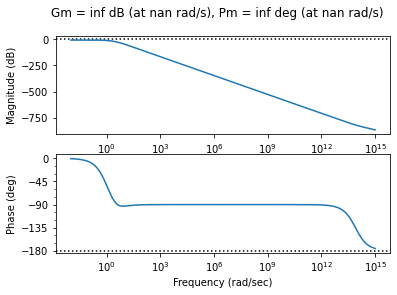

In [17]:
w, mag, phase = bode_plot(transfer_function, dB=True, margins=True)

- As $\omega \rightarrow 0$, the magnitude and the phase approach $0$.
- As $\omega \rightarrow \infty$, the magnitude approaches $-\infty$, while the phase approaches $-180°$.

The phase margin is $\infty$ or $180°$ (as the magnitude never reaches $0$) and gain margin is $\infty dB$ (as the phase never reaches $-180°$).

### 6 Simulate closed-loop system.

Simulation of the system with control. Comparison of Pole placement and LQR methods also provided.

[2.65000000e+01 2.62089928e+01 2.59212394e+01 ... 4.21581881e-08
 4.17390834e-08 4.13240502e-08]


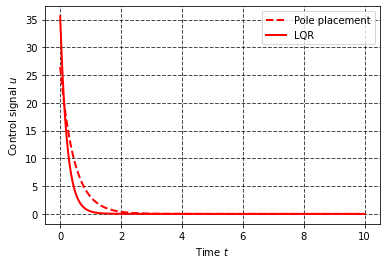

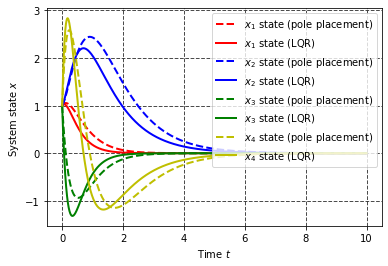

In [18]:
def control(x, K):
    u = -np.dot(K, x)
    return u

def system_ode(x, t, A, B, K):
     u = -np.dot(K, x)
     dx = np.dot(A, x) + np.dot(B, u)
     return dx

def calculate_control(t, x_sol, K):
     u = np.zeros(t.shape)
     for i in range(len(t)):
          u[i] = control(x_sol[i], K)
     return u


t0 = 0  # Initial time
tf = 10  # Final time
N = int(2E3)  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span
x0 = np.array([1, 1, 1, 1])

A = np.array([[0, 0, 1, 0],
     [0, 0, 0, 1],
     [n, -2, -10/n, -2],
     [-5, -n/10, 0, -3]])
B = np.array([[0],
     [0],
     [-1],
     [1]])
C = np.array([[1, 1, 0, 0]])
D = np.array([[0]])



# Pole placement
x_sol_pp = odeint(system_ode, x0, t, args=(A, B, K_pp))
u_pp = calculate_control(t, x_sol_pp, K_pp)
print(u_pp)

# LQR
x_sol_lqr = odeint(system_ode, x0, t, args=(A, B, K_lqr))
u_lqr = calculate_control(t, x_sol_lqr, K_lqr)

plot(t, u_pp, 'r', linestyle='--', linewidth=2., label=r'Pole placement')
plot(t, u_lqr, 'r', linewidth=2., label=r'LQR')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
ylabel(r'Control signal $u$')
xlabel(r'Time $t$')
show()

plot(t, x_sol_pp[:, 0], 'r', linestyle='--',
     linewidth=2., label=r'$x_1$ state (pole placement)')
plot(t, x_sol_lqr[:, 0], 'r', linewidth=2., label=r'$x_1$ state (LQR)')
plot(t, x_sol_pp[:, 1], 'b', linestyle='--',
     linewidth=2., label=r'$x_2$ state (pole placement)')
plot(t, x_sol_lqr[:, 1], 'b', linewidth=2., label=r'$x_2$ state (LQR)')
plot(t, x_sol_pp[:, 2], 'g', linestyle='--',
     linewidth=2., label=r'$x_3$ state (pole placement)')
plot(t, x_sol_lqr[:, 2], 'g', linewidth=2., label=r'$x_3$ state (LQR)')
plot(t, x_sol_pp[:, 3], 'y', linestyle='--',
     linewidth=2., label=r'$x_4$ state (pole placement)')
plot(t, x_sol_lqr[:, 3], 'y', linewidth=2., label=r'$x_4$ state (LQR)')
legend(loc='upper right')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
ylabel(r'System state $x$')
xlabel(r'Time $t$')
show()


### 7 Modify the control law in such a way that the state of the system converges to $x_0 = \begin{bmatrix} (2+0.1n)/(n-5) \\ 1 \\ 0 \\ 0 \end{bmatrix}$. Show resulting control law. Simulate the system and demostrate convergence via graphs of state dynamics and error dynamics.

For $n = 20$: $x_0 = \begin{bmatrix} 4/15 \\ 1 \\ 0 \\ 0 \end{bmatrix}$. I will use $K$ from LQR method.

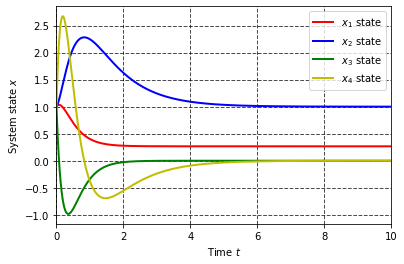

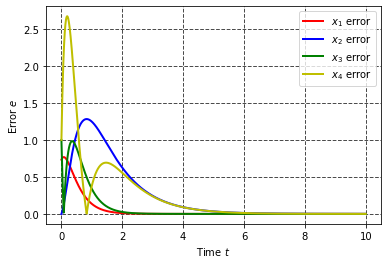

In [19]:
def trajectory():
  x_des = np.array([(2+0.1*n)/(n-5), 1, 0, 0])
  dx_des = np.array([0, 0, 0, 0])
  return x_des, dx_des


def StateSpace_trajectory(x, t, A, B, K):
  x_des, dx_des = trajectory()
  u_ff = np.linalg.pinv(B) @ (dx_des - A @ x_des)
  u_fb = - K @ (x-x_des)
  u = u_fb + u_ff
  return A @ x + B @ u

t0 = 0  # Initial time
tf = 10  # Final time
N = int(2E3)  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span
x0 = np.array([1, 1, 1, 1])

A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])
B = np.array([[0],
              [0],
              [-1],
              [1]])
C = np.array([[1, 1, 0, 0]])
D = np.array([[0]])

x0 = np.array([1, 1, 1, 1])
x_des = np.array([(2+0.1*n)/(n-5), 1, 0, 0])

x_sol = odeint(StateSpace_trajectory, x0, t, args=(A, B, K_lqr))

plot(t, x_sol[:, 0], 'r', linewidth=2.0, label=r'$x_1$ state')
plot(t, x_sol[:, 1], 'b', linewidth=2.0, label=r'$x_2$ state')
plot(t, x_sol[:, 2], 'g', linewidth=2.0, label=r'$x_3$ state')
plot(t, x_sol[:, 3], 'y', linewidth=2.0, label=r'$x_4$ state')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
xlim([t0, tf])
ylabel(r'System state $x$')
xlabel(r'Time $t$')
show()

plot(t, np.abs(x_sol[:, 0] - x_des[0]), 'r', linewidth=2., label=r'$x_1$ error')
plot(t, np.abs(x_sol[:, 1] - x_des[1]), 'b', linewidth=2., label=r'$x_2$ error')
plot(t, np.abs(x_sol[:, 2] - x_des[2]), 'g', linewidth=2., label=r'$x_3$ error')
plot(t, np.abs(x_sol[:, 3] - x_des[3]), 'y', linewidth=2., label=r'$x_4$ error')
legend()
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
ylabel(r'Error $e$')
xlabel(r'Time $t$')
show()


### 8 Discretize the system with $\Delta t = 0.01$. Write equations of the discrete dynamics.

$$\Delta t = T = 0.01$$
$$
\begin{cases} 
\mathbf{x} [(k+1)T] = \mathbf{A_dx} [kT] + \mathbf{B_du} [kT]\\
\mathbf{y} [kT] = \mathbf{C_dx} [kT] + \mathbf{D_du} [kT]
\end{cases}
$$
where
*   $\mathbf{A_d} = (I + T\mathbf{A})$
*   $\mathbf{B_d} = T\mathbf{B}$
*   $\mathbf{C_d} = \mathbf{C}$
*   $\mathbf{D_d} = \mathbf{D}$

$$
\begin{cases}
\mathbf{x} [(k+1)T] = 
\begin{bmatrix} 
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0.2 & -0.02 & 0.995 & -0.02 \\
-0.05 & -0.02 & 0 & 0.97
\end{bmatrix}
\mathbf{x} [kT]
+ 
\begin{bmatrix} 
0 \\
0 \\
-0.01\\
0.01
\end{bmatrix}
\mathbf{u} [kT] \\
\mathbf{y} [kT] = \begin{bmatrix} 
1 & 1 & 0 & 0
\end{bmatrix} \mathbf{x} [kT]
\end{cases}
$$


### 9 Propose a control law for the discrete system via pole-placement and LQR (show cost function for the LQR).

**Pole placement method**

$$ 
\begin{cases}
\mathbf{x} [(k+1)T] = 
\begin{bmatrix} 
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0.2 & -0.02 & 0.995 & -0.02 \\
-0.05 & -0.02 & 0 & 0.97
\end{bmatrix}
\mathbf{x} [kT]
+ 
\begin{bmatrix} 
0 \\
0 \\
-0.01\\
0.01
\end{bmatrix}
\mathbf{u} [kT] \\
\mathbf{u} [kT] =- \mathbf{Kx} [kT]= - \begin{bmatrix}
k_1 & k_2 & k_3 & k_4
\end{bmatrix} \mathbf{x} [kT]
\end{cases}
$$

$$
\mathbf{x} [(k+1)T]=(\mathbf{A_d} - \mathbf{B_d}\mathbf{K})\mathbf{x}[kT] =\begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0.01k_1+0.2 & 00.1k_2-0.02 & 0.01k_3+0.995 & 0.01k_4-0.02\\
-0.01k_1-0.05 & -0.01k_2-0.02 & -0.01k_3 & -0.01k_4+0.97
\end{bmatrix}$$

$$
\det \left(\begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0.01k_1+0.2 & 00.1k_2-0.02 & 0.01k_3+0.995 & 0.01k_4-0.02\\
-0.01k_1-0.05 & -0.01k_2-0.02 & -0.01k_3 & -0.01k_4+0.97
\end{bmatrix} - \begin{bmatrix} \lambda & 0 & 0 & 0\\ 
0 & \lambda & 0 & 0\\
0 & 0 & \lambda & 0\\
0 & 0 & 0 & \lambda\\
\end{bmatrix} \right)=0
$$

Solving the equation leads to four lambda roots. 
The system will be stable if $|\lambda_i| = \sqrt{\operatorname{Re}(\lambda_i)^2 + \operatorname{Im}(\lambda_i)^2} \leq 1,\forall i$. Let's assume that $\lambda_1=0.99$, $\lambda_2=0.98$, $\lambda_3=0.97$, $\lambda_4=0.96$ which we will call poles.

In [20]:
# Pole placement
T = 0.01
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])

B = np.array([[0],
              [0],
              [-1],
              [1]])
A_d = np.eye(4) + T * A
B_d = T * B
P_pp_d = np.array([0.99, 0.98, 0.97, 0.96])
K_pp_d = place_poles(A_d, B_d, P_pp_d).gain_matrix
# verifying eigenvalues
Lambda, _ = eig(A_d - B_d @ K_pp_d)
print(f"Eigenvalues:\n{Lambda}")
print(f"Calculated gains:")
round_expr(sp.Matrix(K_pp_d), 2)

Eigenvalues:
[0.99 0.98 0.97 0.96]
Calculated gains:


Control law is the following:
$u =  - \begin{bmatrix}-26 & 2 & -4.5 & 2\end{bmatrix}
\mathbf{x}$


**Linear quadratic regulator (LQR) method**

I choose the following cost functions:

performace (state): 
$$ Q = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 4
\end{bmatrix}
$$
energy (input):
$$
R = 
\begin{bmatrix} 
10
\end{bmatrix}
$$

In [21]:
# LQR
Q = np.array([[1, 0, 0, 0],
              [0, 2, 0, 0],
              [0, 0, 3, 0],
              [0, 0, 0, 4]])
R = np.array([[10]])
K_lqr_d, _, _ = dlqr(A_d, B_d, Q, R)
print(f"Calculated gains:")
round_expr(sp.Matrix(K_lqr_d), 2)

Calculated gains:


Control law is the following:
$u =  - \begin{bmatrix}-32.0 & 2.1 & -6.6 & 2.1\end{bmatrix}
\mathbf{x}$

### 10 Show eigenvalue analisys of the сlosed-loop dynamics of the discrete system (with the proposed discrete control law). Demonstrate stability.

Using pole placement method we have already know (by our assumption) that $|\lambda_i| = \sqrt{\operatorname{Re}(\lambda_i)^2 + \operatorname{Im}(\lambda_i)^2} \leq 1,\forall i$, so the system is stable.

Let's compute eigenvalues for obtained control low from LQR method:

In [22]:
l, v = eig(A_d - B_d @ K_lqr_d)
print(r'\mathbf{\lambda} = ' + latex(round_expr(sp.Matrix(l), 2)))

\mathbf{\lambda} = \left[\begin{matrix}0.99\\0.97\\0.96\\0.96\end{matrix}\right]


$$
\mathbf{\lambda} = \begin{bmatrix}0.99\\0.97\\0.96\\0.96\end{bmatrix}
$$
So, again $|\lambda_i| = \sqrt{\operatorname{Re}(\lambda_i)^2 + \operatorname{Im}(\lambda_i)^2} \leq 1,\forall i$, so the system is stable.

### 11 Simulate the discrete system. Show graphs.

Simulation of the system with control. Comparison of Pole placement and LQR methods also provided.

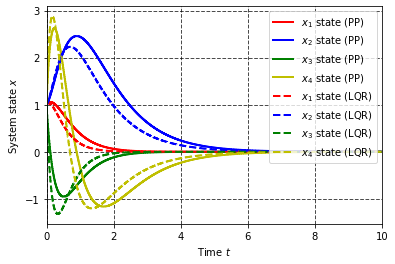

In [23]:
t0 = 0  # Initial time
tf = 10  # Final time
T = 0.01  # Discretization step
t = np.arange(t0, tf, T)  # Create time span

A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])

B = np.array([[0],
              [0],
              [-1],
              [1]])

x0 = np.array([1, 1, 1, 1])


A_d = np.eye(4) + T * A
B_d = T * B

x_disc_pp = x0
x_disc_lqr = x0

x_d = x0
x_disc = x0
for time in t:
  u_d = - K_pp_d @ x_d
  x_d = A_d @ x_d + B_d @ u_d
  x_disc_pp = np.vstack((x_disc_pp, x_d))

x_d = x0
x_disc = x0
for time in t:
  u_d = - K_lqr_d @ x_d
  x_d = A_d @ x_d + B_d @ u_d
  x_disc_lqr = np.vstack((x_disc_lqr, x_d))

t_disc = np.insert(t, 0, 0)

step(t_disc, x_disc_pp[:, 0], 'r', linewidth=2.0, label=r'$x_1$ state (PP)')
step(t_disc, x_disc_pp[:, 1], 'b', linewidth=2.0, label=r'$x_2$ state (PP)')
step(t_disc, x_disc_pp[:, 2], 'g', linewidth=2.0, label=r'$x_3$ state (PP)')
step(t_disc, x_disc_pp[:, 3], 'y', linewidth=2.0, label=r'$x_4$ state (PP)')

step(t_disc, x_disc_lqr[:, 0], 'r', linestyle='--',
     linewidth=2.0, label=r'$x_1$ state (LQR)')
step(t_disc, x_disc_lqr[:, 1], 'b', linestyle='--',
     linewidth=2.0, label=r'$x_2$ state (LQR)')
step(t_disc, x_disc_lqr[:, 2], 'g', linestyle='--',
     linewidth=2.0, label=r'$x_3$ state (LQR)')
step(t_disc, x_disc_lqr[:, 3], 'y', linestyle='--',
     linewidth=2.0, label=r'$x_4$ state (LQR)')
legend(loc='upper right')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'System state $x$')
xlabel(r'Time $t$')
show()


### 12 Find Lyapunov function that proves the system's stability (one for continious time and one discrete time versions).

Let's find Lyapunov functions (S) for 
$$Q = \begin{bmatrix}1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \end{bmatrix}$$

Eigenvalues of S:  [4.00291139 3.03376741 0.06287073 0.12106493]
S is positive definite?  True
S (countinuous):


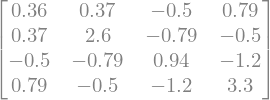

In [24]:
T = 0.01  # Discretization step
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [n, -2, -10/n, -2],
              [-5, -n/10, 0, -3]])
B = np.array([[0],
              [0],
              [-1],
              [1]])
# positive definite Q, but with minus because of equation in solve_continuous_lyapunov
Q = - np.eye(4)

S_c = solve_continuous_lyapunov(A - B @ K_lqr, Q)
print("Eigenvalues of S: ", eig(S_c)[0])
print("S is positive definite? ", (eig(S_c)[0] >= 0).all())
print("S (countinuous):")
round_expr(sp.Matrix(S_c), 2)


Satisfies $A^TS + SA + Q = 0$.

Eigenvalues of S: [415.07845823 312.78416272   6.84288307  12.3210958 ]
S is positive definite?  True
S (discrete):


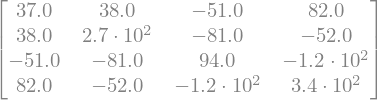

In [25]:
Q = np.eye(4)  # positive definite
A_d = np.eye(4) + T * A
B_d = T * B
S_d = solve_discrete_lyapunov(A_d - B_d @ K_lqr_d, Q)
print("Eigenvalues of S:", eig(S_d)[0])
print("S is positive definite? ", (eig(S_d)[0] >= 0).all())
print("S (discrete):")
round_expr(sp.Matrix(S_d), 2)


Satisfies $A^TSA - S = - Q$.

# Task 2 (4 points)

You are given a system:

$$ 
\begin{cases}
\dot x = 
\begin{bmatrix} 
1 & 5 & -2 \\
2 & 1 & -3 \\
-1 & -2 & 7
\end{bmatrix}
x
+ 
\begin{bmatrix} 
2 \\
1 \\
0
\end{bmatrix}
u \\
u = -\begin{bmatrix} 
7k & 6k & -50k
\end{bmatrix} x
\end{cases}
$$

### 1 How do the eigenvalues of the closed-loop system depend on k? Plot the evolution of the eigenvalues on a complex plane, as $k$ changes from 0 to 5. 




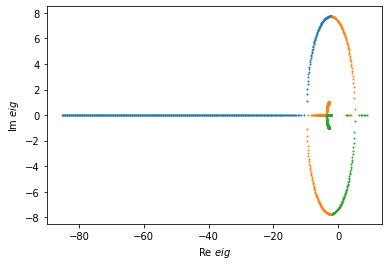

In [26]:
A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
k0 = 0
kf = 5
kstep = 0.01
eigs = []

for k in np.arange(k0, kf, kstep):
     K = np.array([[7*k, 6*k, -50*k]])
     lambdas, _ = eig(A - B @ K)
     eigs.append(lambdas)
eigs = np.array(eigs)
ks = np.array([np.arange(k0, kf, kstep), np.arange(k0, kf, kstep),
      np.arange(k0, kf, kstep)]).transpose()

plot(np.real(eigs), np.imag(eigs), 'o', markersize=1)
xlabel(r'Re $eig$')
ylabel(r'Im $eig$')
show()



### 2 Chose a value of $k$ that allows the system to be stable. Use bode plot to find stability margins of the closed-loop system.

- Continuous case

In [27]:
A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
k0 = 0
kf = 5
kstep = 0.001

for k in np.arange(k0, kf, kstep):
     K = np.array([[7*k, 6*k, -50*k]])
     lambdas, _ = eig(A - B @ K)
     # condition for the continuous system to be stable
     if (np.real(lambdas[0]) <= 0 and np.real(lambdas[1]) <= 0 and np.real(lambdas[2]) <= 0):
          print(k, lambdas)
          break


0.5730000000000001 [-2.44184911+0.j         -0.00907545+7.32684079j -0.00907545-7.32684079j]


So, the first $k$ we have found is $0.573$.

- Discrete case

In [28]:
T = 0.05  # discretization step from task 2.3
A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
A_d = np.eye(3) + T * A
B_d = T * B
k0 = 0
kf = 5
kstep = 0.001

for k in np.arange(k0, kf, kstep):
     K = np.array([[7*k, 6*k, -50*k]])
     lambdas, _ = eig(A_d - B_d @ K)
     # condition for the discrete system to be stable
     if (np.abs(lambdas[0]) <= 1 and np.abs(lambdas[1]) <= 1 and np.abs(lambdas[2]) <= 1):
          print(k, lambdas)
          break


0.729 [0.92301145+0.3843821j 0.92301145-0.3843821j 0.87497709+0.j       ]


The second $k$ we have found is $0.729$. So, let's assume that greater $k$ (for example $k=0.9$ will satisfy both cases) and check it:

In [29]:
k = 0.9
K = np.array([[7*k, 6*k, -50*k]])
# continuous system
lambdas, _ = eig(A - B @ K)
print("Continuous:", lambdas)
# continuous system
lambdas, _ = eig(A_d - B_d @ K)
print("Discrete:", lambdas)
print("K = ", K)


Continuous: [-3.21757699+7.69688374j -3.21757699-7.69688374j -2.56484603+0.j        ]
Discrete: [0.83912115+0.38484419j 0.83912115-0.38484419j 0.8717577 +0.j        ]
K =  [[  6.3   5.4 -45. ]]


So in both cases $k = 0.9$ satisfies the stability conditions. The control law then:
$$u = -\begin{bmatrix}
6.3 & 5.4 & -45
\end{bmatrix}\mathbf{x}$$

TransferFunction(array([  2., -11., -29.]), array([ 1., -9., -3., 48.]))

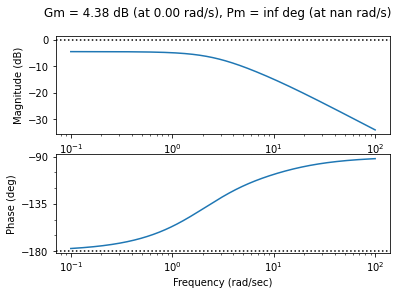

In [30]:
# Solution using scipy and control. Bode plot
A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
C = np.array([[1, 0, 0]])
D = 0
tf_num, tf_den = ss2tf(A, B, C, D)
transfer_function = transfer_func(tf_num[0], tf_den)
w, mag, phase = bode_plot(transfer_function, dB=True, margins=True)
transfer_function

- As $\omega \rightarrow 0$, the magnitude approaches $0$, while the phase approach $-180°$.
- As $\omega \rightarrow \infty$, the magnitude approaches $-\infty$, while the phase approaches $-90°$.

The phase margin is $\infty$ or $180°$ (as the magnitude never reaches $0$) and gain margin is $4.38 dB$.

### 3 Discretize the closed-loop system with $\Delta t = 0.05$ and simulate both the continues-time and discrete-time versions, show if there is a difference between simulation results.

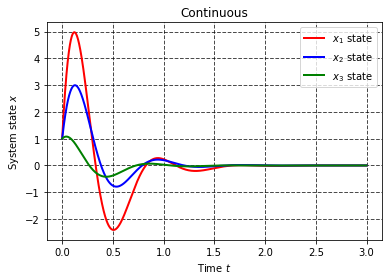

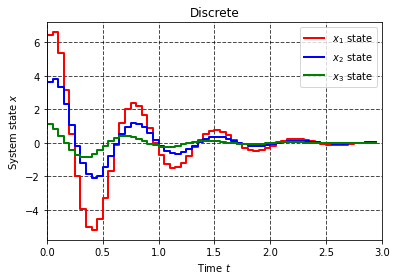

In [31]:
k = 0.9

t0 = 0  # Initial time
tf = 3  # Final time

A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
K = np.array([[7*k, 6*k, -50*k]])
x0 = np.array([1, 1, 1])

N = int(2E3)  # Numbers of points in time span
t = np.linspace(t0, tf, N)  # Create time span

x_sol = odeint(system_ode, x0, t, args=(A, B, K))

plot(t, x_sol[:, 0], 'r', linewidth=2., label=r'$x_1$ state')
plot(t, x_sol[:, 1], 'b', linewidth=2., label=r'$x_2$ state')
plot(t, x_sol[:, 2], 'g', linewidth=2., label=r'$x_3$ state')
legend(loc='upper right')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
grid(True)
title('Continuous')
ylabel(r'System state $x$')
xlabel(r'Time $t$')
show()

T = 0.05  # Discretization step
t = np.arange(t0, tf, T)  # Create time span
A_d = np.eye(3) + T * A
B_d = T * B

x_d = x0
x_disc = x0
for time in t:
  u_d = - K @ x_d
  x_d = A_d @ x_d + B_d @ u_d
  x_disc = np.vstack((x_disc, x_d))

t_disc = np.insert(t, 0, 0)

step(t_disc, x_disc[:, 0], 'r', linewidth=2.0, label=r'$x_1$ state')
step(t_disc, x_disc[:, 1], 'b', linewidth=2.0, label=r'$x_2$ state')
step(t_disc, x_disc[:, 2], 'g', linewidth=2.0, label=r'$x_3$ state')
legend(loc='upper right')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
title('Discrete')
ylabel(r'System state $x$')
xlabel(r'Time $t$')
show()


So, there is difference in amplitude of the states (in discrete case it is a bit bigger). The discrete case also needs more time to stabilize.

### 4 What is the smallest value of $k$ that makes the eigenvalues purely real?

_Remark_: the system should be stable. Let's brute-force!!!

In [32]:
T = 0.05  # Discretization step
A = np.array([[1, 5, -2],
              [2, 1, -3],
              [-1, -2, 7]])
B = np.array([[2],
              [1],
              [0]])
A_d = np.eye(3) + T * A
B_d = T * B
k0 = 0
kf = 5
kstep = 0.00001

for k in np.arange(k0, kf, kstep):
    K = np.array([[7*k, 6*k, -50*k]])
    lambdas_c, _ = eig(A - B @ K)
    lambdas_d, _ = eig(A_d - B_d @ K)
    # condition for the continuous and discrete system to be stable and eigenvalues are purely real
    if (np.imag(lambdas_c) == 0).all() and (np.imag(lambdas_d) == 0).all() and (np.real(lambdas_c) <= 0).all() and (np.abs(lambdas_d) <= 1).all():
        print(k, lambdas_c)
        print(k, lambdas_d)
        break
print("K = ", K)


1.57735 [-9.87951525 -9.81328994 -2.85419481]
1.57735 [0.50602424 0.5093355  0.85729026]
K =  [[ 11.04145   9.4641  -78.8675 ]]


The smallest value is $k = 1.57735$ that satisfies conditions. The control law then:
$$u = -\begin{bmatrix}
11.04145 & 9.4641 & -78.8675
\end{bmatrix}\mathbf{x}$$

# Task 3 (3 points)

You are given a system:

$$ 
\begin{cases}
\dot x = 
\begin{bmatrix} 
0 & 1 \\
1 & 10
\end{bmatrix}
x
+ 
\begin{bmatrix} 
0 \\
1
\end{bmatrix}
u \\
u = 
-\begin{bmatrix} 
5k & k
\end{bmatrix} x
\end{cases}
$$

You can chose any positive value of $k$ to design your controller. What is least-norm control gain (control gain is the matrix $\begin{bmatrix} 5k & k \end{bmatrix}$) that makes the system not only be stable, but also exhibit no oscillations in the transient process?

Let's define bounds for $k$:
- $k$ is positive,
- Least-norm control gain means we should find the smallest $k$,
- Stable system means for continuous: $\operatorname{Re}(\lambda_i) \leq 0, \forall i$,
- Exhibit no oscillations in the transient process means the eqigenvalues should have zero imaginary part or, in other words, a discriminant greater or equal to zero.

Using _pole placement method_, let's find such $k$:

In [37]:
A = sp.Matrix([[0, 1],
              [1, 10]])
B = sp.Matrix([[0],
              [1]])

k, l = sp.symbols('k \lambda')
K = sp.Matrix([[5*k, k]])

M = sp.Matrix((A - B @ K) - sp.eye(2) * l)

det = M.det()
l_1, l_2 = sp.solve(det, l)

# condition bounds:
positive = sp.solve(k > 0)
no_oscillations = sp.solve(sp.discriminant(det, l) >= 0).simplify()  # roots will be purely real
stability_1 = sp.solve(l_1 <= 0).simplify()
stability_2 = sp.solve(l_2 <= 0).simplify()

result = (positive & no_oscillations & stability_1 & stability_2).simplify()
result


Therefore, for $k = 2\sqrt{74}+20$ we will have the following control gain (it will satisfy all conditions above):
$$u = -\begin{bmatrix}
10\sqrt{74} + 100 & 2\sqrt{74} + 20
\end{bmatrix}\mathbf{x} =
-\begin{bmatrix}
186.02 & 37.2
\end{bmatrix}\mathbf{x}$$